# Class Workbook

## In class activity

In [2]:
import numpy as np
from scipy.special import expit

import seaborn as sns
import math
from matplotlib.pyplot import subplots
import matplotlib.pyplot as plt
import pandas as pd
#import statsmodels.api as sm
from plotnine import *
import plotly.express as px
import plotly.graph_objects as go
import statsmodels.formula.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve
import patchworklib as pw
from mpl_toolkits.mplot3d import Axes3D

#import ISLP as islp

<Figure size 100x100 with 0 Axes>

### Simulated example

Let's simulate lightbulb life time in minutes using exponential distribution.
Let's say we have A light bulb with rate 0.001 and B light bulb with rate 0.0015.
We will generate 100 bulbs each.

In [9]:
np.random.seed(1234)

def lightbulb(n=100, hrate=0.001):
    return np.random.exponential(scale=1/hrate, size=n)

# Generate data for columns A and B
df = pd.DataFrame({
    'A': lightbulb(100, 0.001),
    'B': lightbulb(100, 0.0015)
})
df

,A,B
0,212.598658,971.478334
1,973.148879,820.931087
2,575.769096,1062.596831
3,1538.786474,543.936287
4,1514.017776,2251.065595
...,...,...
95,698.279455,307.653240
96,769.765177,618.123247
97,1710.375264,72.543903
98,58.811632,1080.919897


There are many ways to look at this data.

### 50 hour survival

For example, how many survived 50 hours?

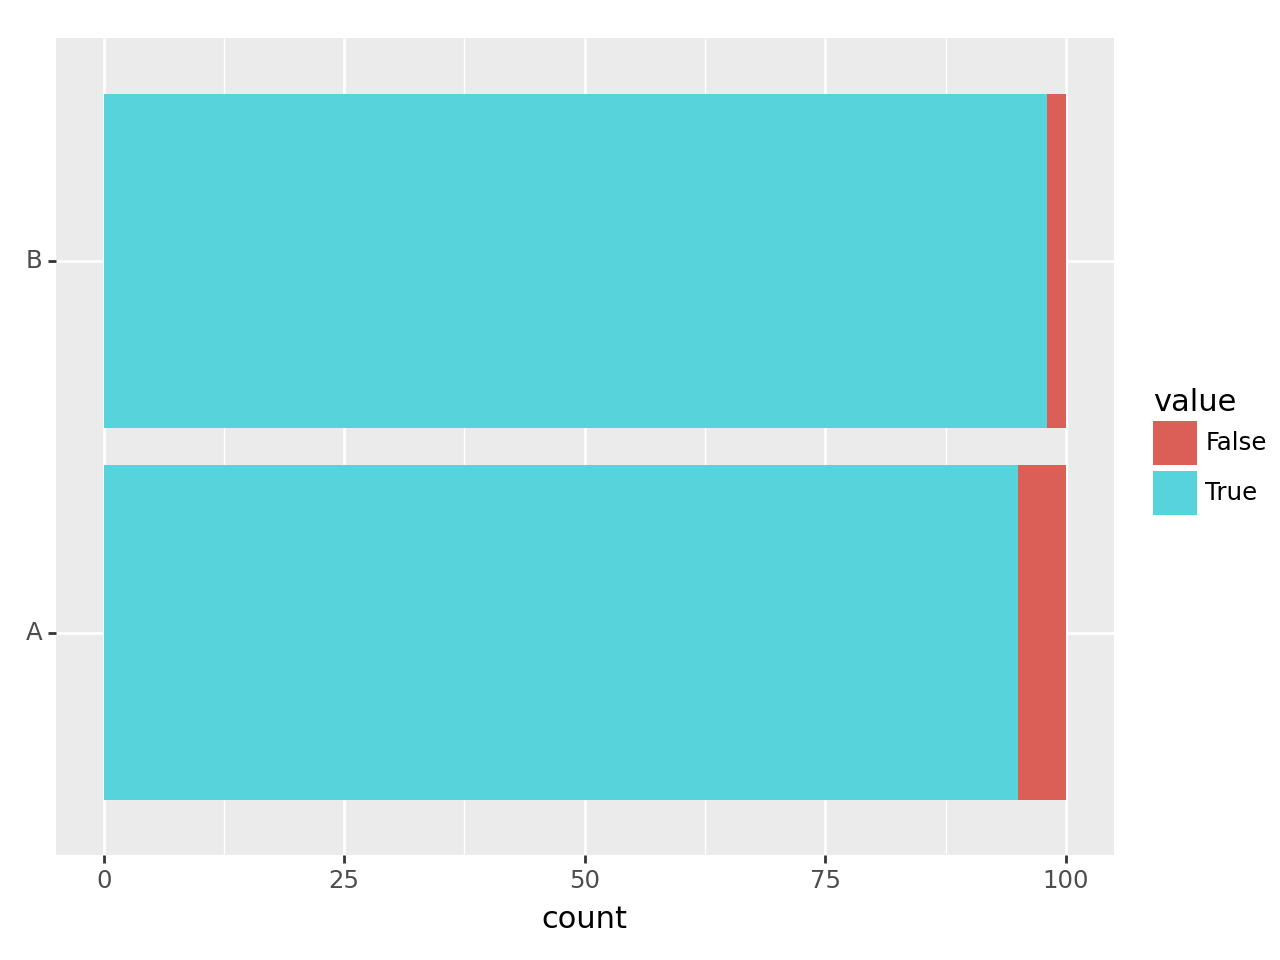

<Figure Size: (640 x 480)>

In [10]:
df_melt=pd.melt(df<3000)
(
 ggplot(df_melt)+geom_bar()+aes(x="variable", fill="value")+xlab("")+coord_flip()
)

### Rate by 10 hour window

Or the counts of how many died in every 10 hour window.

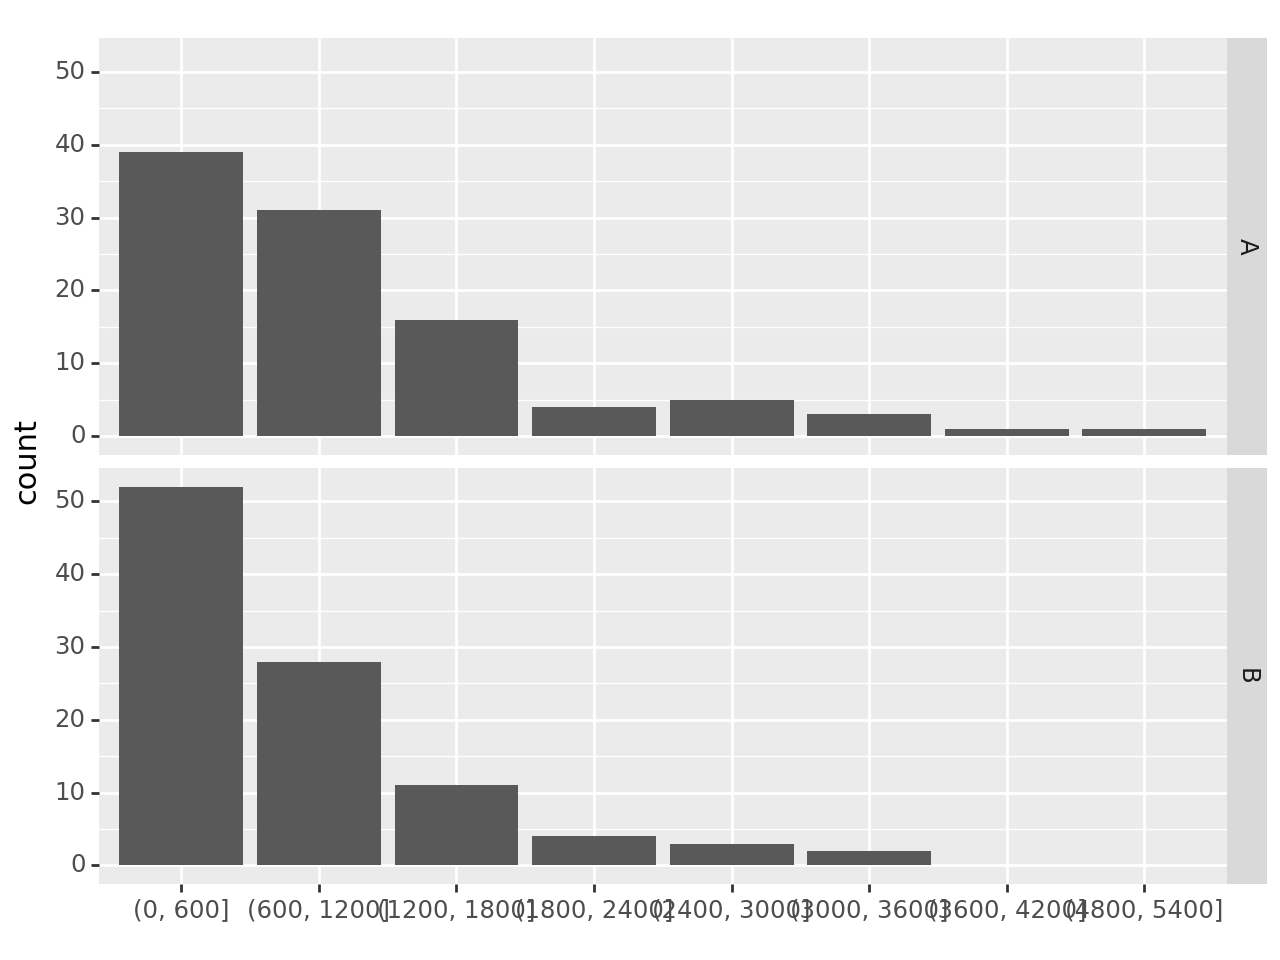

<Figure Size: (640 x 480)>

In [11]:
bin_edges = np.arange(0, 10001, 600)
bin_edges[-1] = 10000  # Ensure the last bin ends at 10000

# Apply the cut function to each column of the DataFrame
dfdisc = df.apply(lambda x: pd.cut(x, bins=bin_edges))

# Melt the DataFrame
mdfdisc = pd.melt(dfdisc)
(
  ggplot(mdfdisc)+geom_bar()+aes(x="value" )+xlab("")+facet_grid("variable~.")
)

### Hours until the lightbulb burns out

Or, we can look at the hours directly.

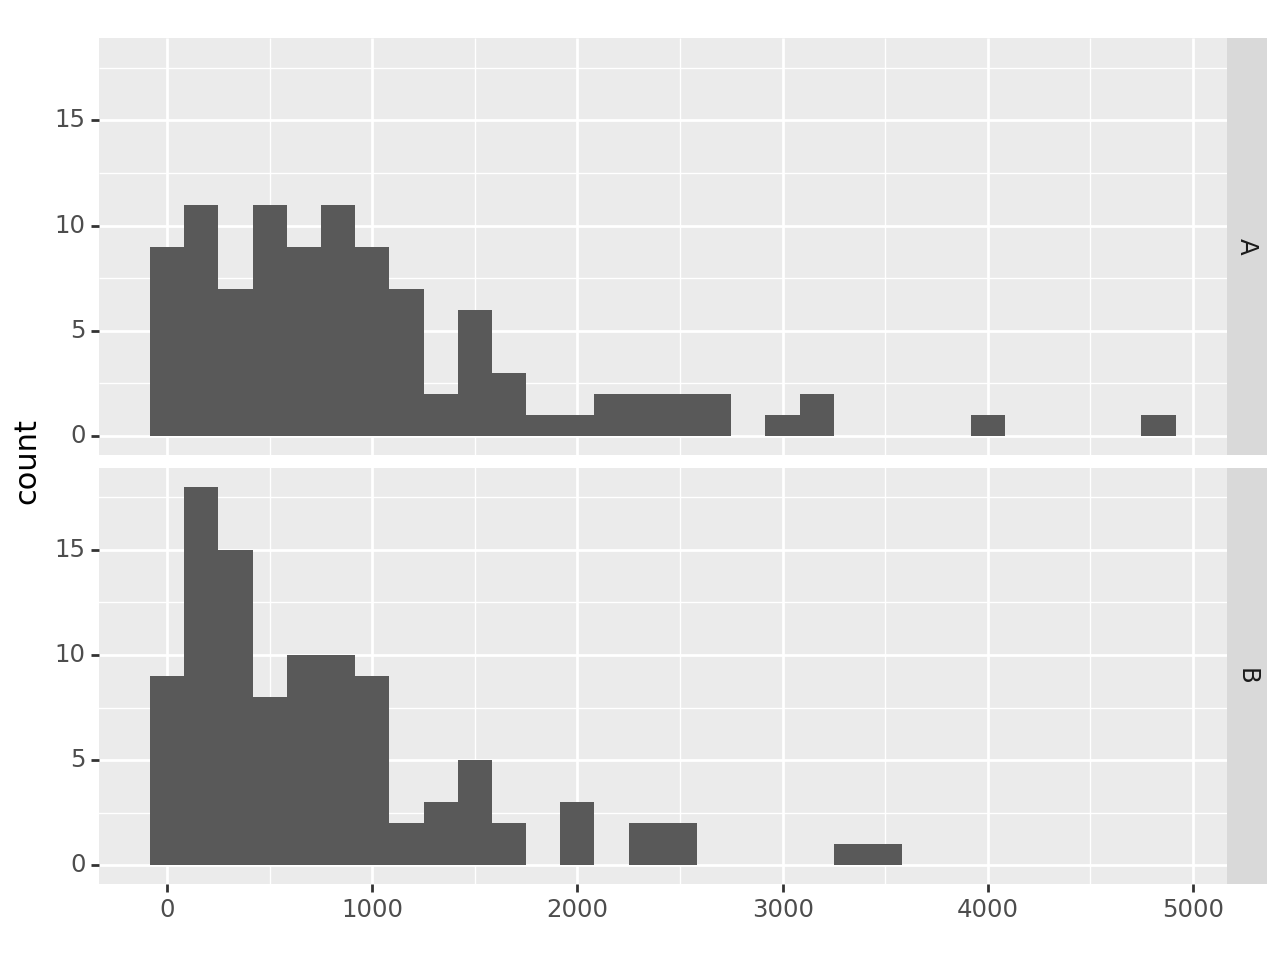

<Figure Size: (640 x 480)>

In [12]:
(
  ggplot(pd.melt(df))+geom_histogram(bins=30)+
  aes(x="value" )+xlab("")+facet_grid("variable~.")
)

### What is the correct way to analyze?

Depending on the research question the way to analyze the data will be different.

- For the binary problem, you can use logistic regression.
- For the counts you can use Poisson regression with offset.
- For the hours, it depends on the shape of the distribution.

First take away message: It is important is to understand that not all survival analysis requires a complex survival analysis model.  The question then is what requires survival analysis?

### The Veterans' Administration Lung Cancer Trial

Survival in patients with advanced lung cancer from the North Central Cancer Treatment Group. Performance scores rate how well the patient can perform usual daily activities.

- `inst`:	Institution code
- `time`:	Survival time in days
- `status`:	censoring status
  - 1=censored,
  - 2=dead
- `age`:	Age in years
- `sex`:
  - Male=1
  - Female=2
- `ph.ecog`:	ECOG performance score as rated by the physician.
  - 0=asymptomatic,
  - 1= symptomatic but completely ambulatory,
  - 2= in bed <50% of the day,
  - 3= in bed > 50% of the day but not bedbound,
  - 4 = bedbound
- `ph.karno`:	Karnofsky performance score (bad=0-good=100) rated by physician
- `pat.karno`:	Karnofsky performance score as rated by patient
- `meal.cal`:	Calories consumed at meals
- `wt.loss`:	Weight loss in last six months (pounds)

In [13]:
#pip install scikit-survival
# if you get an error you might need to manually install osqp
#https://osqp.org/docs/get_started/sources.html
from lifelines.datasets import load_lung
lung = load_lung()
lung=lung.dropna()

lung["status"]=np.where(lung["status"] == 1, True, False)
data_y=lung.loc[:,["status","time"]]

data_x=lung.loc[:,["inst","age","sex", "ph.ecog","ph.karno",  "pat.karno",  "meal.cal" , "wt.loss"]]

lung_df=lung.loc[:,["status","time","sex","age"]]
lung_df["sex"]=lung_df["sex"] -1
lung_df.dtypes
lung_df.isnull().sum()

lung_df_m=lung_df[lung.sex==1]
lung_df_f=lung_df[lung.sex==2]

### K-M plot

Kaplan-Meier curves shows the empirical survival probability.  This is the first thing people do when they start survival analysis.  There are few ways to plot the same thing.  One way is using `sksurv`.

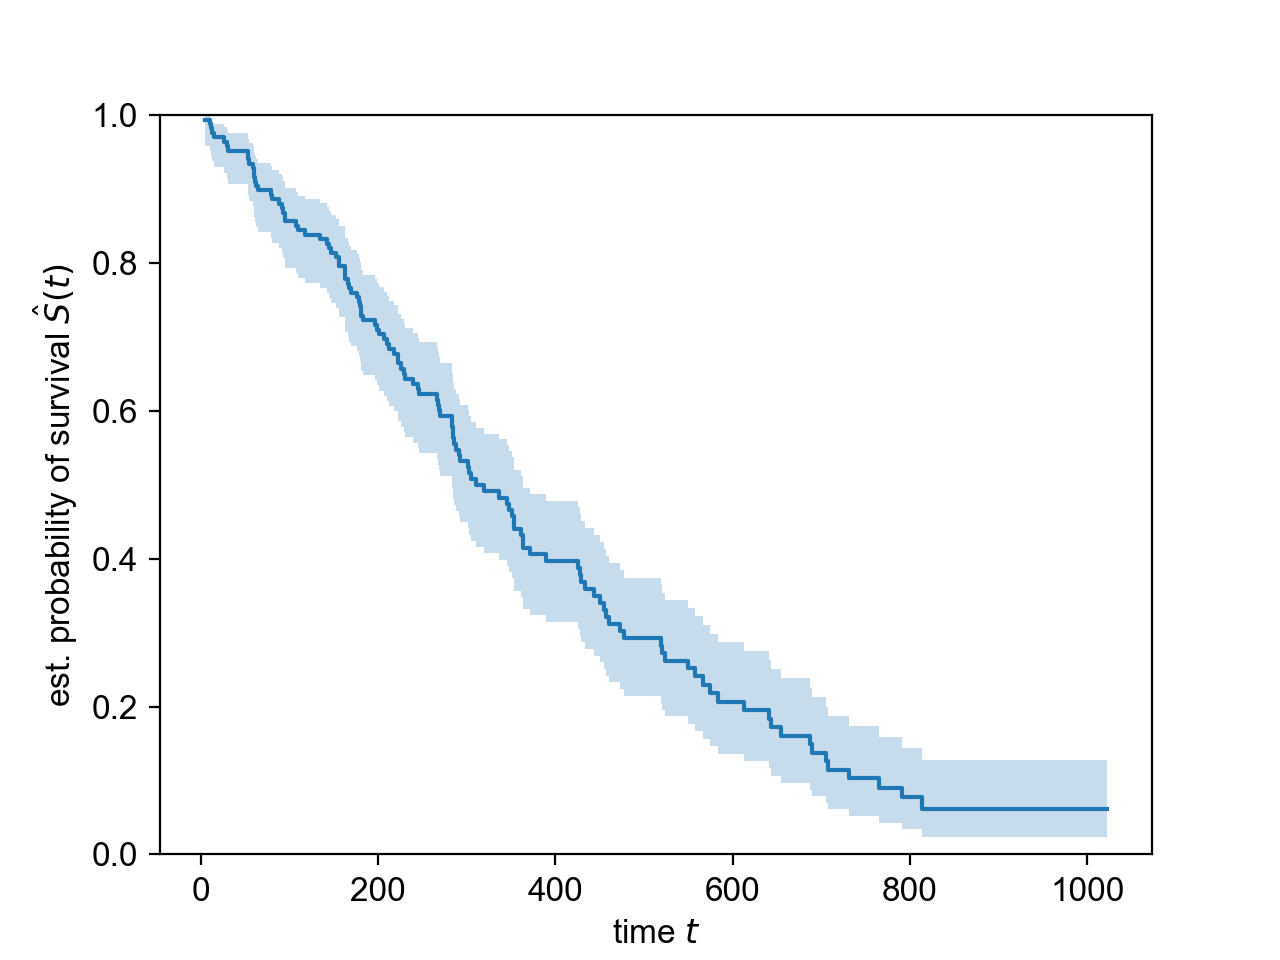

In [19]:

from sksurv.nonparametric import kaplan_meier_estimator # type: ignore

time, survival_prob, conf_int = kaplan_meier_estimator(
    data_y["status"], data_y["time"], conf_type="log-log"
)

plt.step(time, survival_prob, where="post")
plt.fill_between(time, conf_int[0], conf_int[1], alpha=0.25, step="post")
plt.ylim(0, 1)
plt.ylabel(r"est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.show()

The alternative is to use `lifelines`.

<Axes: xlabel='timeline'>

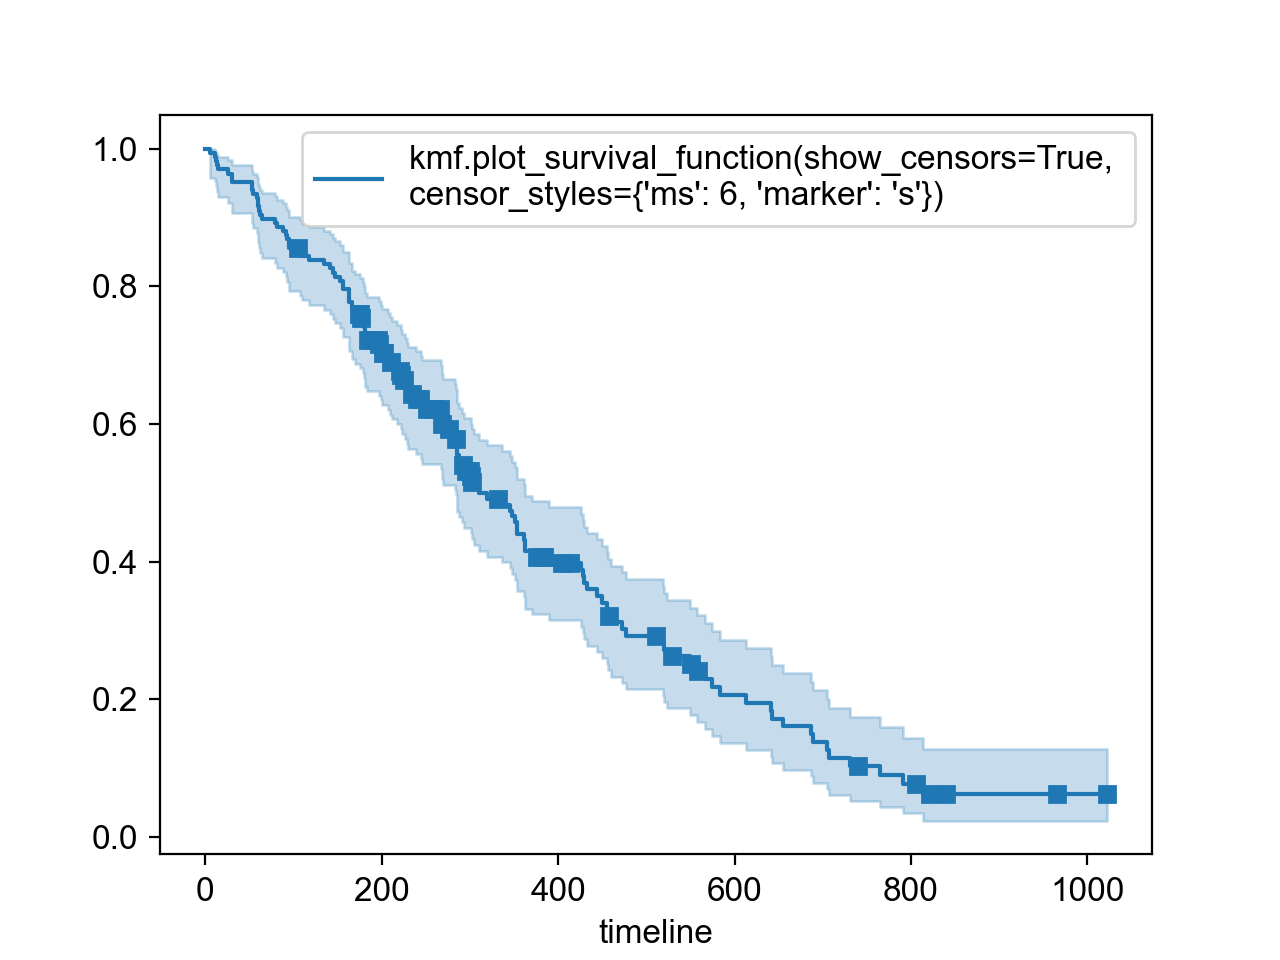

In [20]:
from lifelines import KaplanMeierFitter
kmf=KaplanMeierFitter()
kmf.fit(lung_df['time'], event_observed=lung_df['status'], label="kmf.plot_survival_function(show_censors=True, \ncensor_styles={'ms': 6, 'marker': 's'})")
kmf.plot_survival_function(show_censors=True, censor_styles={'ms': 6, 'marker': 's'})

### Checking for proportional hazard assumption.

We check the proportional hazard assumption by plotting log time vs cloglog survival.  If the proportional hazard assumption hold, then the lines should be parallel.

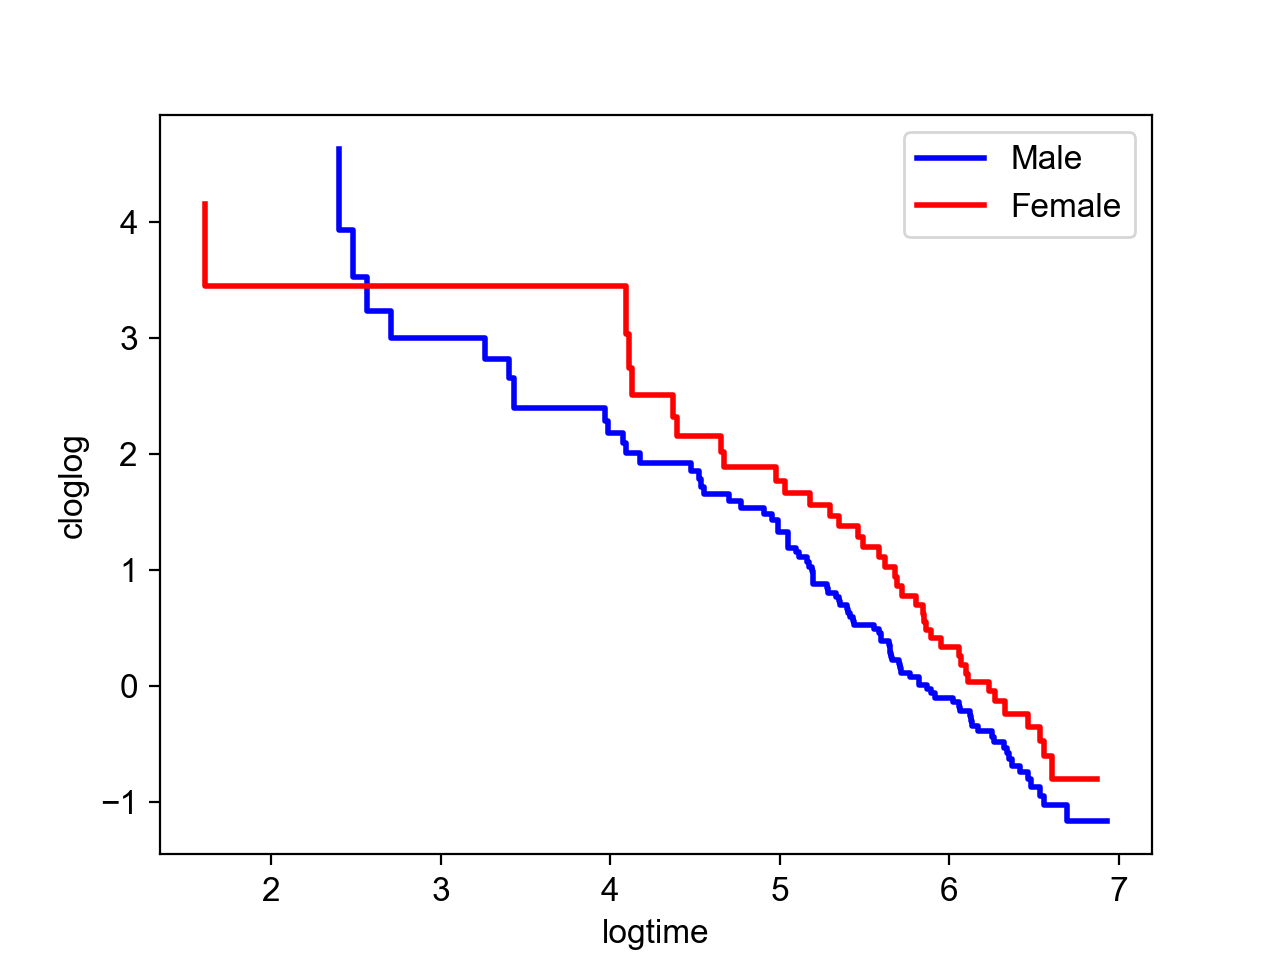

In [21]:
from lifelines import KaplanMeierFitter

def kmsubset(data):
    kmf = KaplanMeierFitter()
    kmf.fit(data['time'], event_observed=data['status'])
    time_0 = kmf.timeline
    surv_0 = kmf.survival_function_
    cloglog_0 = -np.log(-np.log(surv_0))
    logtime_0 = np.log(time_0)
    aa = {'cloglog': cloglog_0, 'logtime': logtime_0}
    return aa

a=kmsubset(data=lung[lung.sex==1] )
b=kmsubset(data=lung[lung.sex==2])

plt.plot(a['logtime'], a['cloglog'], 'blue', linewidth=2, drawstyle='steps', label='Male')
plt.plot(b['logtime'], b['cloglog'], 'red', linewidth=2, drawstyle='steps', label='Female')

plt.xlabel('logtime')
plt.ylabel('cloglog')
plt.legend()
plt.show()

The line seems fairly parallel, which does not prove the proportional hazard assumption but there is no reason to believe otherwise.

The popular model to fit is the Cox Proportional Hazard model

In [22]:
from lifelines import CoxPHFitter
cph = CoxPHFitter()
cph.fit(lung_df,"time","status", formula="sex+age")
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 167 total observations, 47 right-censored observations>
             duration col = 'time'
                event col = 'status'
      baseline estimation = breslow
   number of observations = 167
number of events observed = 120
   partial log-likelihood = -503.68
         time fit was run = 2024-04-20 14:49:30 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
sex        -0.45       0.64       0.20            -0.83            -0.06                 0.43                 0.94
age         0.02       1.02       0.01            -0.00             0.04                 1.00                 1.04

            cmp to     z    p   -log2(p)
covariate                               
sex           0.00 -2.26 0.02       5.40
age           0.00  1.60 0.11       3.20
---
Concordance = 0.60
Partial AIC = 1011.35
log-likelihood ratio test = 8.88 on 2 df
-log2(p) of ll-ratio test = 6.41

The fitted coefficient

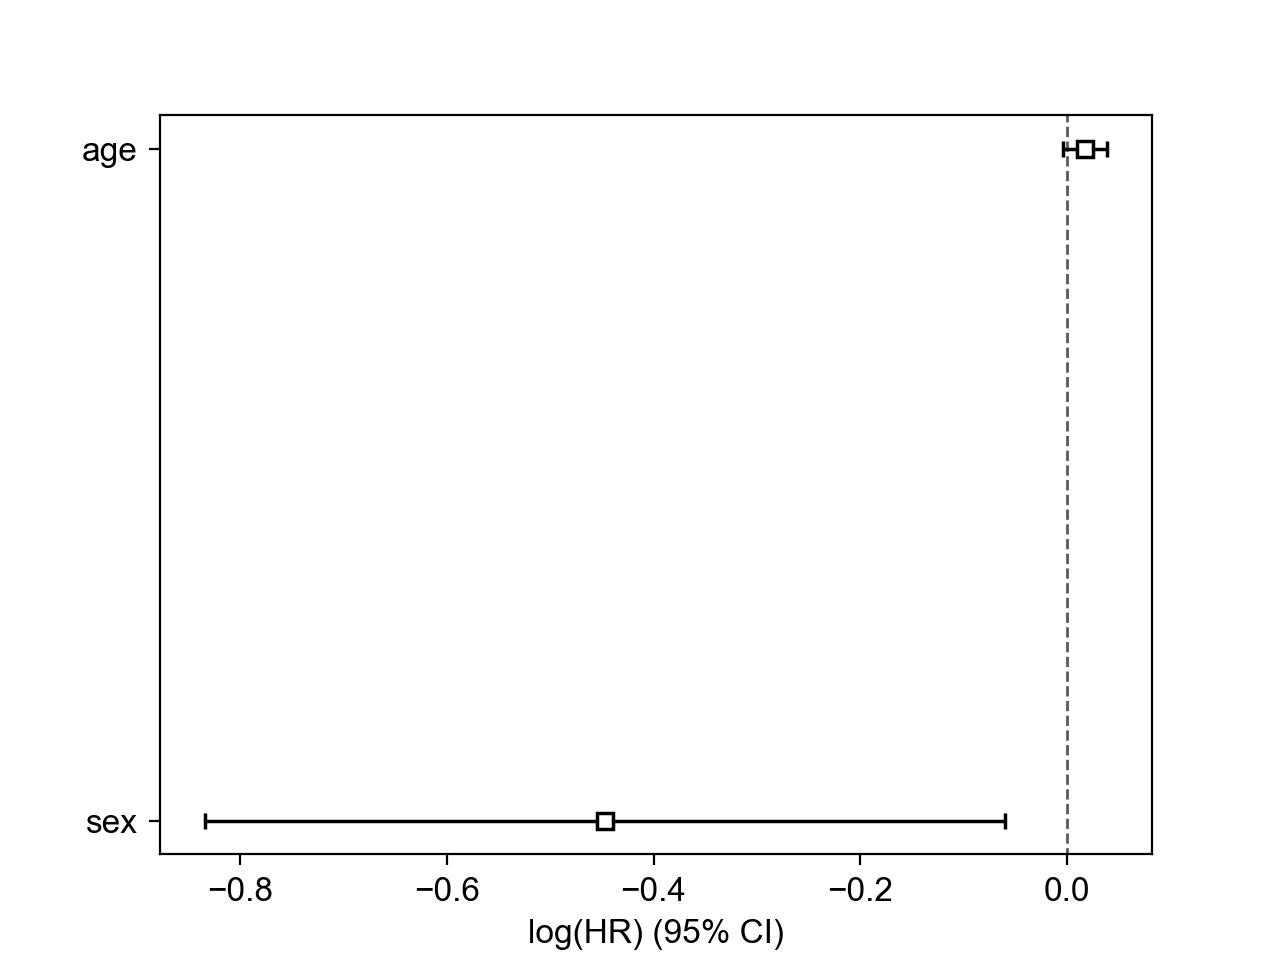

In [23]:
cph.plot()
plt.show()

The estimated survival functions align well with the empirical survival function.

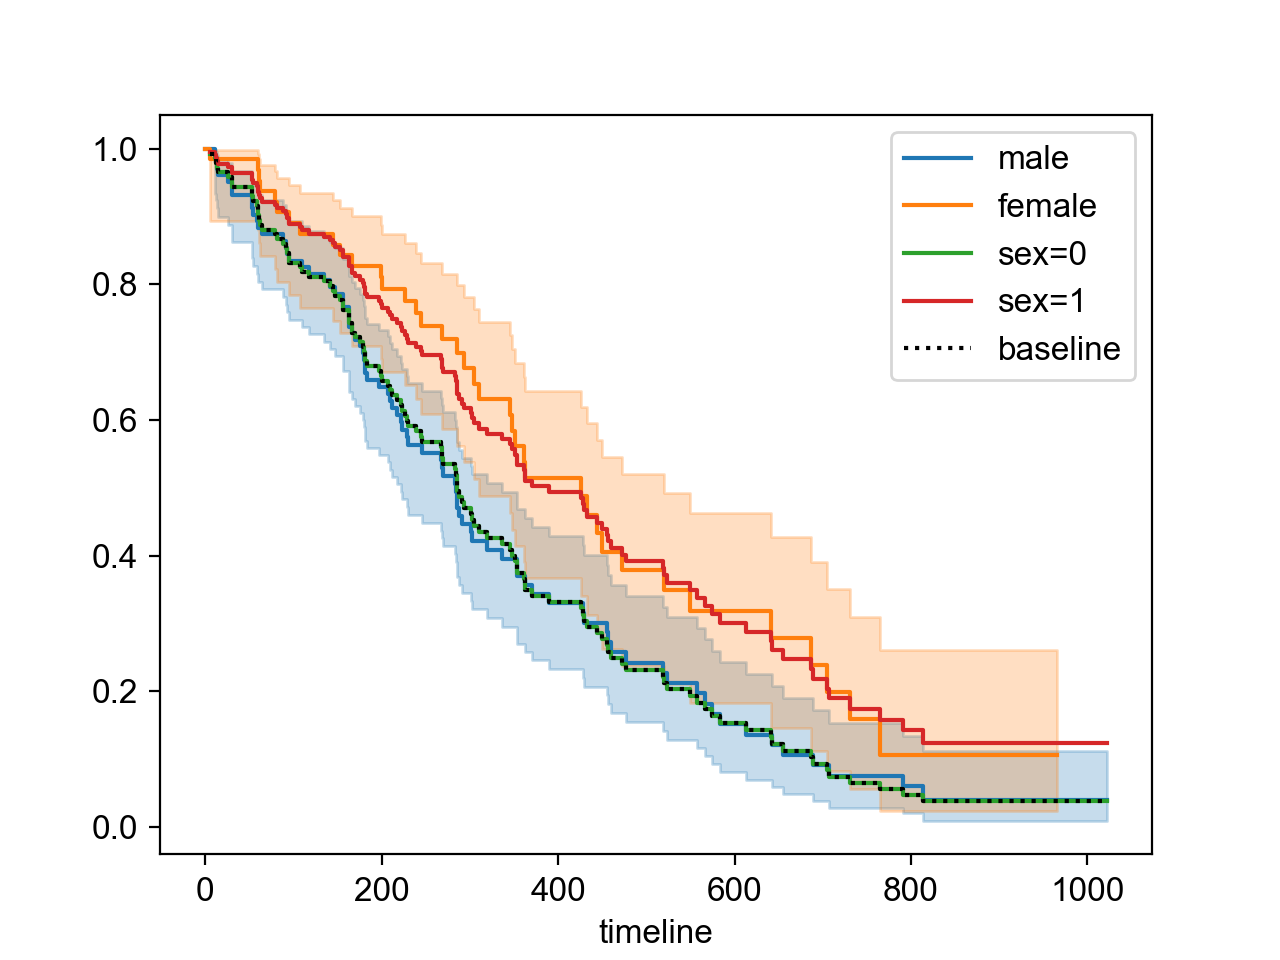

In [24]:
from matplotlib import pyplot as plt
ax = plt.subplot(111)
kmfm = KaplanMeierFitter()
kmfm.fit(lung_df_m['time'], event_observed=lung_df_m['status'], label='male')
kmfm.plot_survival_function(ax=ax)
kmff = KaplanMeierFitter()
kmff.fit(lung_df_f['time'], event_observed=lung_df_f['status'], label='female')
kmff.plot_survival_function(ax=ax)
cph.plot_partial_effects_on_outcome(covariates=["sex"],
                         values=[0,1],ax=ax)
plt.show()

You can plot the estimated curves for different set of predictor values.

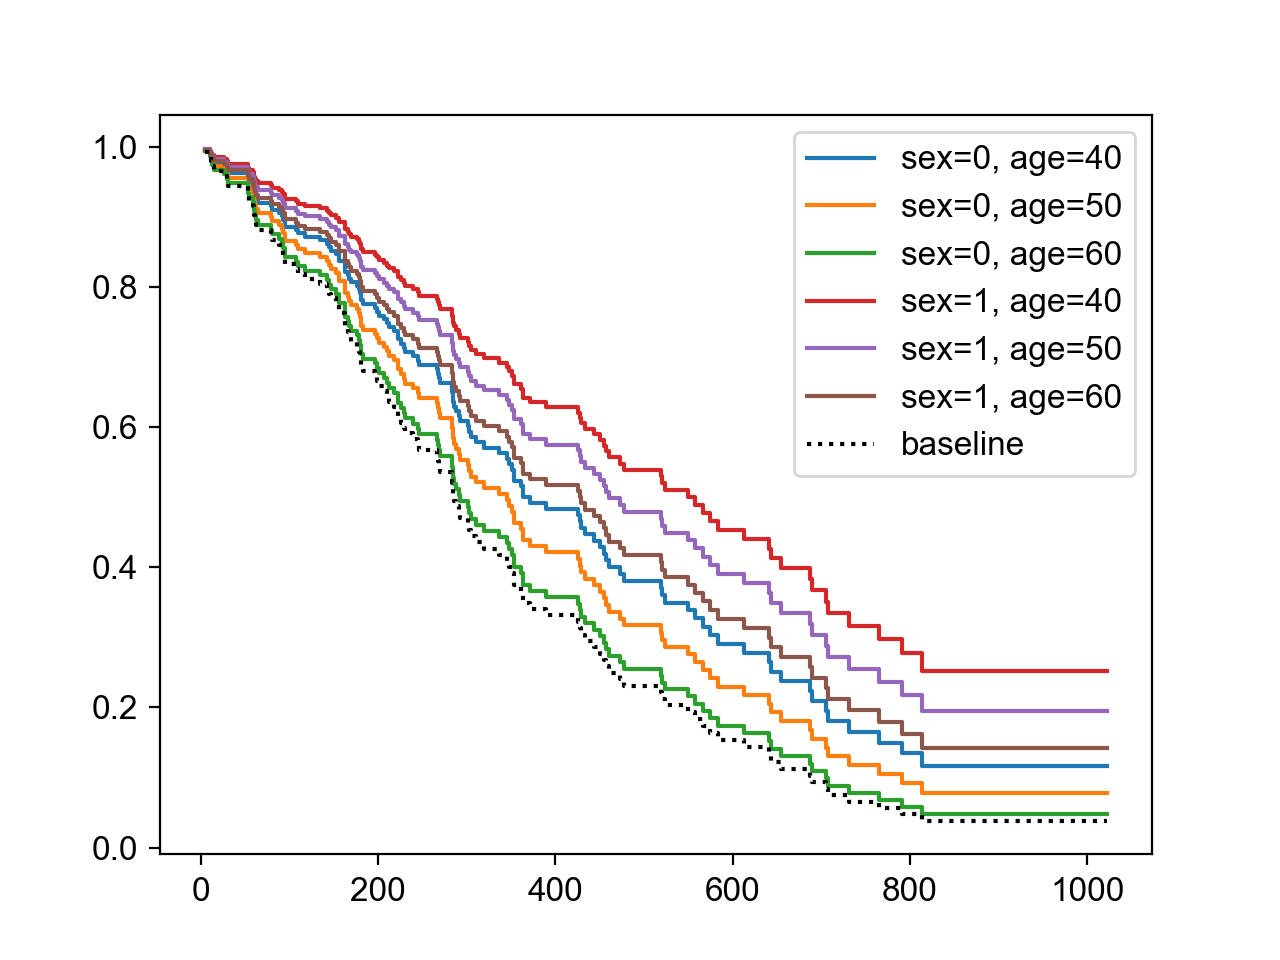

In [25]:
cph.plot_partial_effects_on_outcome(covariates=["sex","age"],
                         values=[[0,40],[0,50],[0,60],
                                  [1,40],[1,50],[1,60]])
plt.show()

### Weibull regression

Following example from Zhang (2016) (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5233524/pdf/atm-04-24-484.pdf  ) we will fit a Weibull regression.

In [26]:
from lifelines import WeibullAFTFitter
weibull_aft = WeibullAFTFitter()
weibull_aft.fit(lung_df, duration_col='time', event_col='status', formula="sex+age")
weibull_aft.print_summary()

<lifelines.WeibullAFTFitter: fitted with 167 total observations, 47 right-censored observations>
             duration col = 'time'
                event col = 'status'
   number of observations = 167
number of events observed = 120
           log-likelihood = -836.88
         time fit was run = 2024-04-20 14:49:31 UTC

---
                    coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
param   covariate                                                                                                         
lambda_ Intercept   6.65     773.60       0.52             5.63             7.67               279.98              2137.44
        sex         0.33       1.40       0.15             0.04             0.62                 1.05                 1.86
        age        -0.01       0.99       0.01            -0.03             0.00                 0.97                 1.00
rho_    Intercept   0.30       1.35       0.07             0.16             0.44                 1.17                 1.56

                    cmp to     z      p   -log2(p)
param   covariate                                 
lambda_ Intercept     0.00 12.83 <0.005     122.69
        sex           0.00  2.26   0.02       5.39
        age           0.00 -1.43   0.15       2.72
rho_    Intercept     0.00  4.10 <0.005      14.56
---
Concordance = 0.60
AIC = 1681.77
log-likelihood ratio test = 8.37 on 2 df
-log2(p) of ll-ratio test = 6.04

Weibull model seem to fit well.

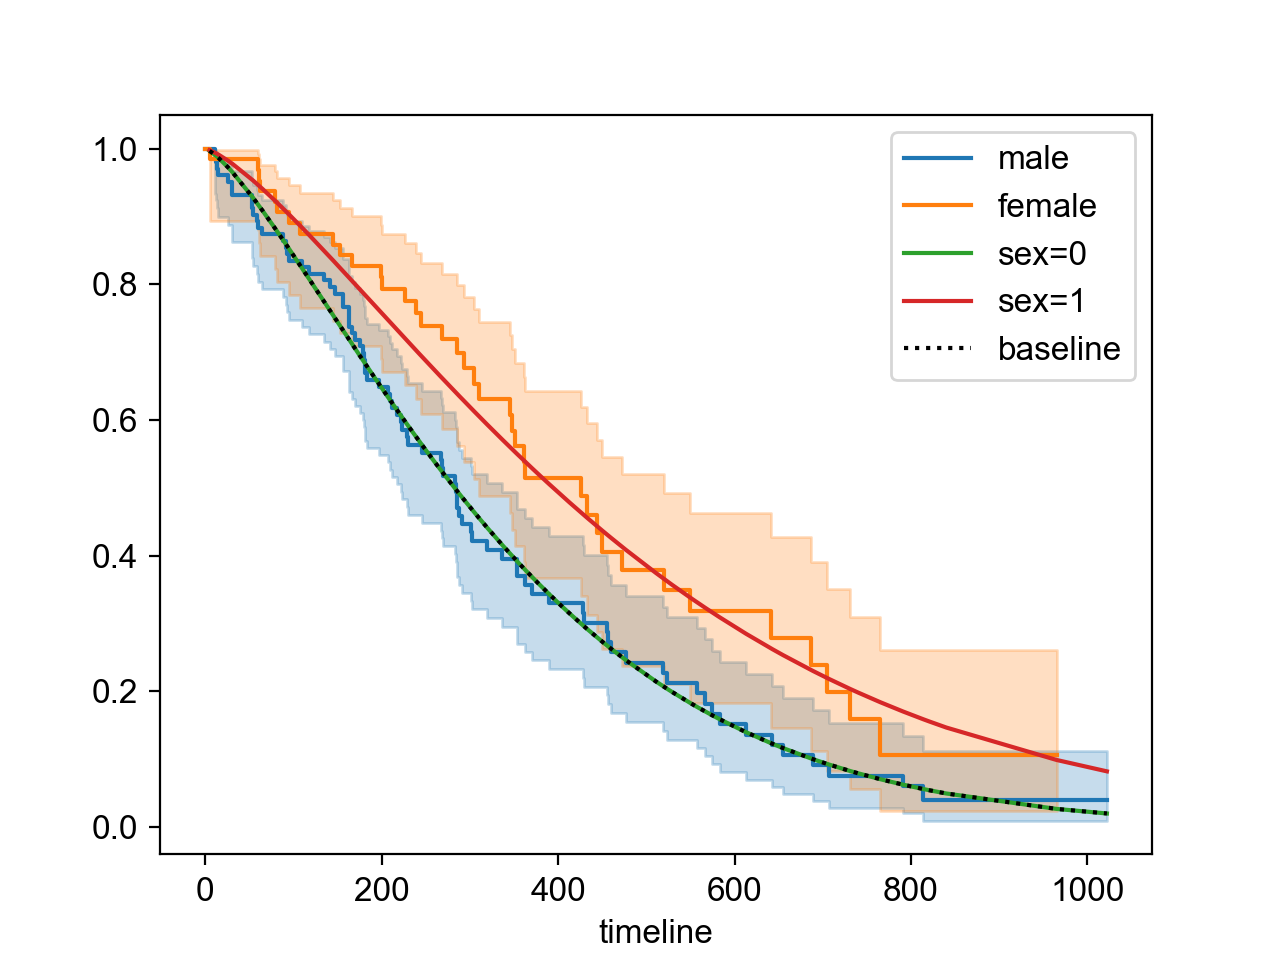

In [27]:
ax = plt.subplot(111)
kmfm.plot_survival_function(ax=ax)
kmff.plot_survival_function(ax=ax)
weibull_aft.plot_partial_effects_on_outcome(covariates=["sex"],
                         values=[0,1],ax=ax)
plt.show()

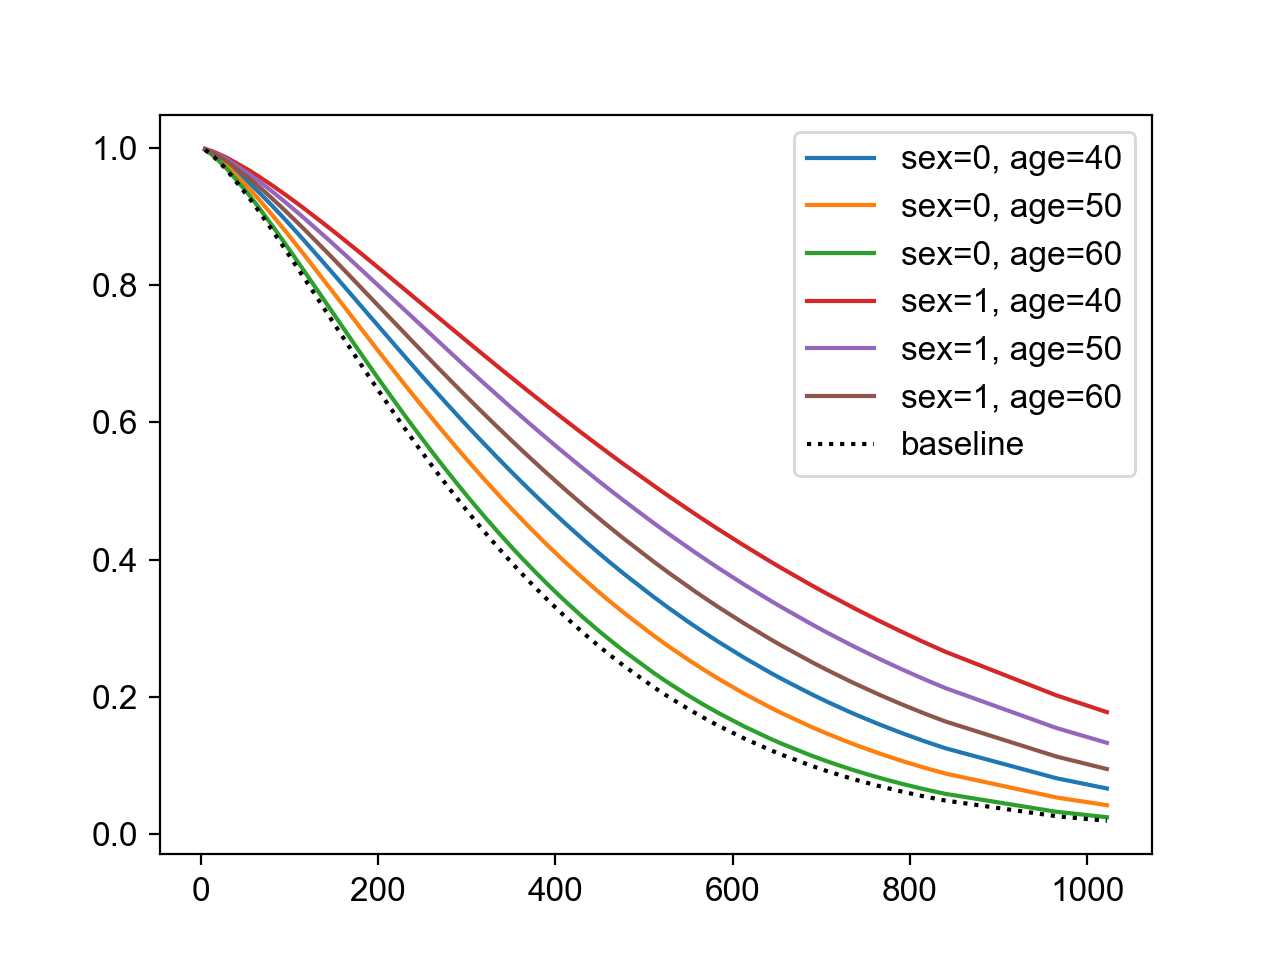

In [28]:
weibull_aft.plot_partial_effects_on_outcome(covariates=["sex","age"],
                         values=[[0,40],[0,50],[0,60],
                                  [1,40],[1,50],[1,60]])


plt.show()

### Concordance index

The concordance index is a value between 0 and 1 where:

- 0.5 is the expected result from random predictions,
- 1.0 is perfect concordance and,
- 0.0 is perfect anti-concordance (multiply predictions with -1 to get 1.0)

In [29]:
from lifelines.utils import concordance_index
concordance_index(lung_df['time'], -cph.predict_partial_hazard(lung_df), lung_df['status'])
concordance_index(lung_df['time'], -weibull_aft.predict_expectation(lung_df), lung_df['status'])

0.39928057553956836

### AIC model search

1681.7671721996721 1011.3529896511118


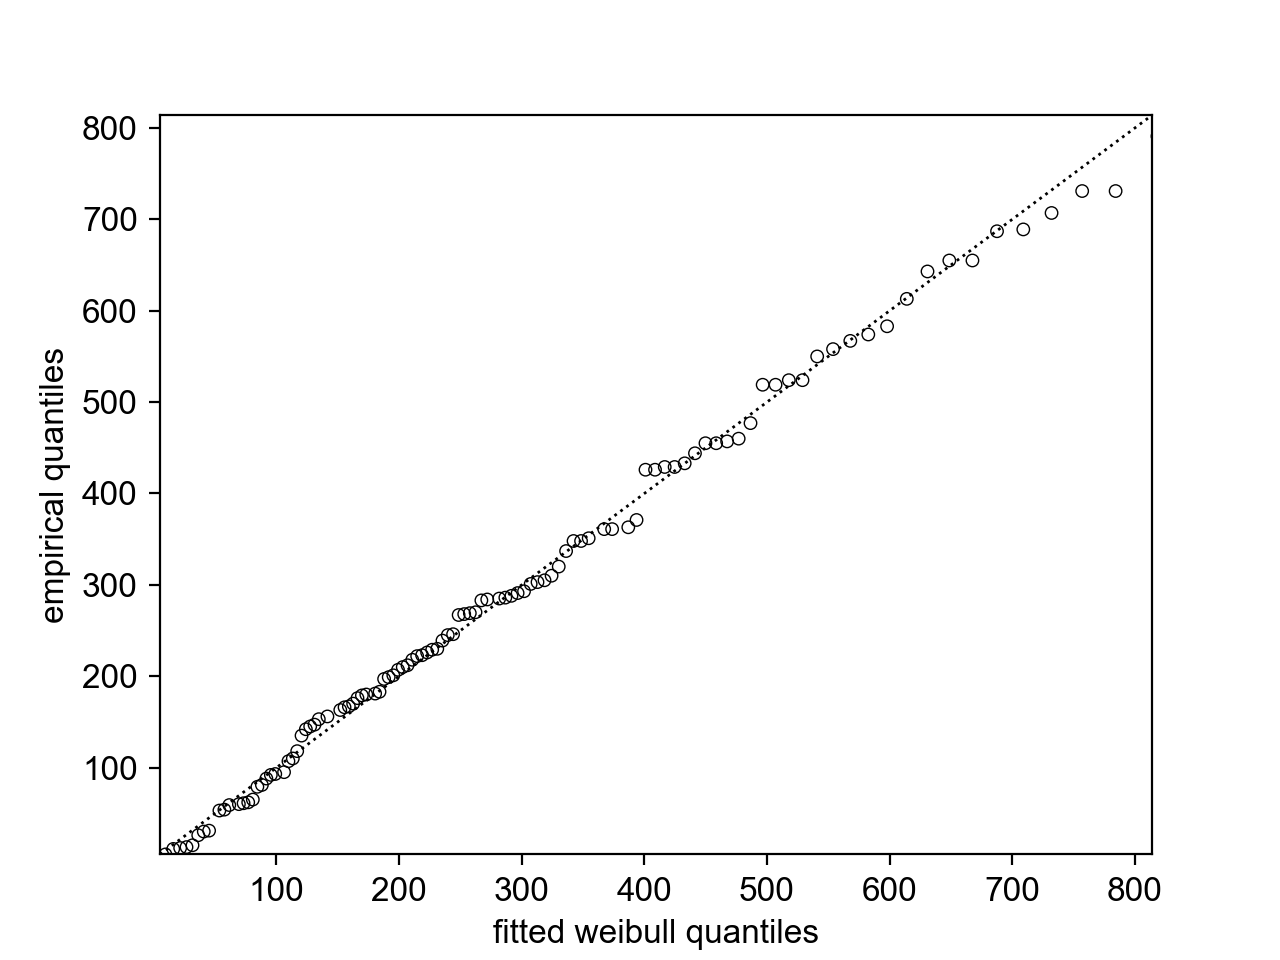

In [30]:
print(weibull_aft.AIC_, cph.AIC_partial_)
from lifelines.utils import find_best_parametric_model
best_model, best_aic_ = find_best_parametric_model(event_times=lung_df['time'],
                                                      event_observed=lung_df['status'],
                                                 scoring_method="AIC")

from lifelines.plotting import qq_plot
qq_plot(best_model)
plt.show()

### Log-rank test

In [31]:
from lifelines.statistics import logrank_test
results = logrank_test(lung_df_m['time'], lung_df_f['time'], event_observed_A=lung_df_m['status'], event_observed_B=lung_df_f['status'])
results.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           6.05 0.01      6.16

## Problem Set

### Brain Tumor

This exercise focuses on the brain tumor data, which is included in the ISLR2 R library.

In [42]:
data=pd.read_csv("https://raw.githubusercontent.com/intro-stat-learning/ISLP/main/ISLP/data/BrainCancer.csv")

(a) Plot the Kaplan-Meier survival curve with ±1 standard error
bands, using the `KaplanMeierFitter()` estimator in the lifelines
package.

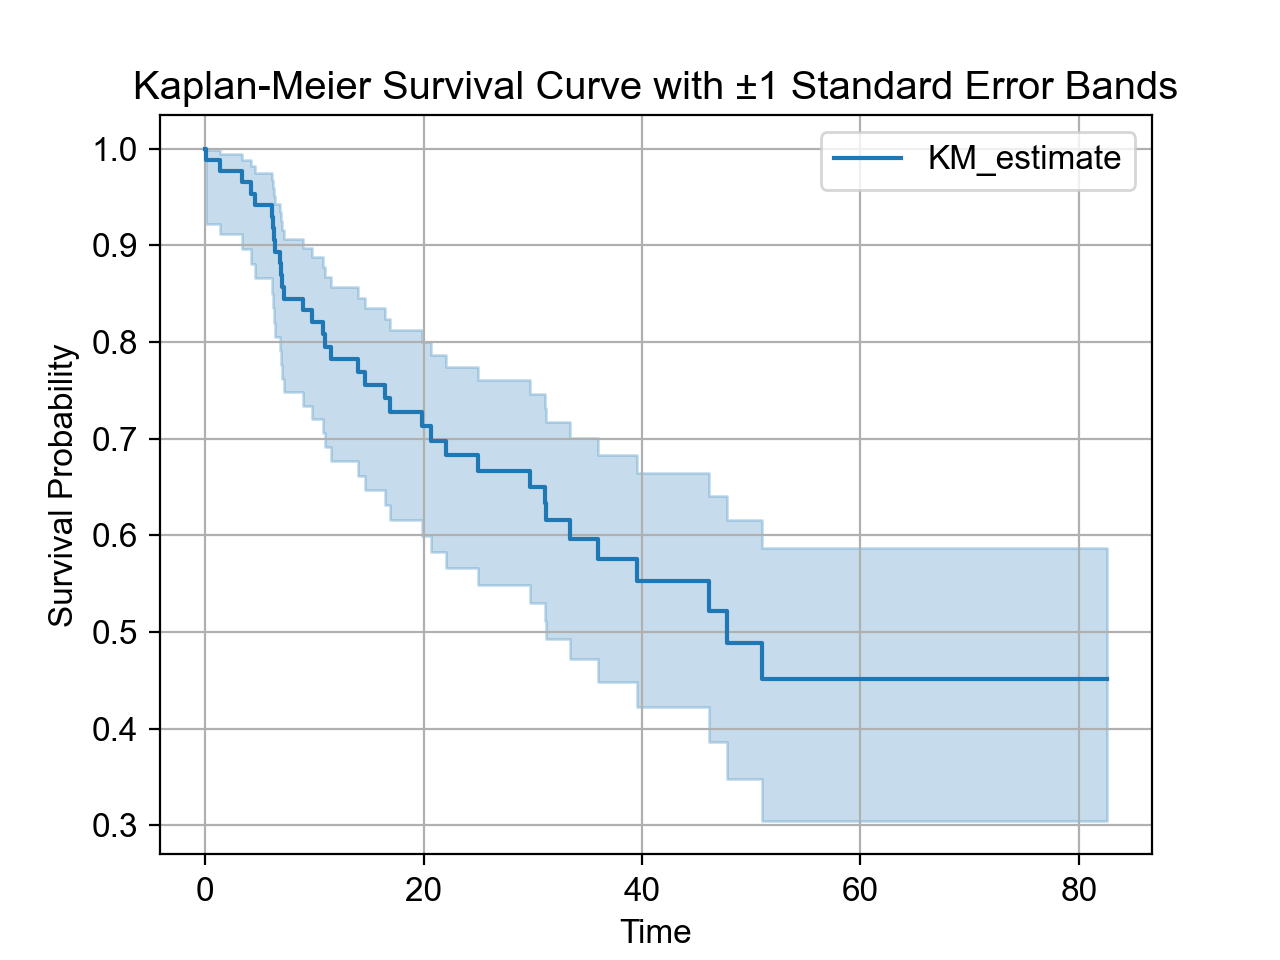

In [43]:
kmf = KaplanMeierFitter()
kmf.fit(durations=data['time'], event_observed=data['status'])
kmf.plot_survival_function(ci_show=True)
plt.title('Kaplan-Meier Survival Curve with ±1 Standard Error Bands')
plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.grid(True)
plt.show()

(b) Draw a bootstrap sample of size $n = 88$ from the pairs ($y_i$, $\delta_i$), and compute the resulting Kaplan-Meier survival curve. Repeat this process B = 200 times. Use the results to obtain an estimate of the standard error of the Kaplan-Meier survival curve at each timepoint. Compare this to the standard errors obtained in (a).

In [67]:
kmf = KaplanMeierFitter()
n = 88  
B = 200 
bootstrap_survivals = {}

for b in range(B):
 
    sample = data.sample(n, replace=True)
    kmf.fit(durations=sample['time'], event_observed=sample['status'])
    survival_function = kmf.survival_function_
    
    for timepoint in survival_function.index:
        if timepoint not in bootstrap_survivals:
            bootstrap_survivals[timepoint] = []
        bootstrap_survivals[timepoint].append(survival_function.loc[timepoint].values[0])


standard_errors = {time: np.std(bootstrap_survivals[time]) for time in bootstrap_survivals}
standard_errors

{0.0: 0.0,
 1.18: 0.011733537072128594,
 1.41: 0.013438825251614701,
 2.03: 0.01636778165811783,
 5.15: 0.02899296280688108,
 6.1: 0.027969963185505622,
 6.23: 0.03252079722103102,
 6.3: 0.033373593071893616,
 6.39: 0.035816501095669265,
 6.82: 0.037150746880899914,
 6.92: 0.04029913456926027,
 7.05: 0.040776219753145916,
 7.18: 0.03863334483177589,
 7.25: 0.042681960859083,
 9.77: 0.04577629130352995,
 11.51: 0.04814869899195716,
 11.57: 0.046756014280431114,
 13.9: 0.0469225645789609,
 14.56: 0.04842447001679108,
 14.75: 0.05332612565107169,
 16.92: 0.05212749519018997,
 19.41: 0.04912323359264313,
 19.74: 0.04899505782405607,
 19.9: 0.0563707985087892,
 20.13: 0.05156094050171556,
 20.69: 0.05537790161719609,
 22.03: 0.059456824582541895,
 23.67: 0.05419702803479991,
 24.39: 0.05468546501972642,
 25.02: 0.055648860607342344,
 26.46: 0.050691430774077076,
 26.85: 0.056408260855495225,
 29.7: 0.060770685046878284,
 30.16: 0.06038023959600914,
 31.25: 0.056258894587728946,
 31.67: 0.05

(c) Fit a Cox proportional hazards model that uses all of the predictors
to predict survival. Summarize the main findings.

In [69]:
data_encoded = pd.get_dummies(data, columns=['sex', 'diagnosis', 'loc', 'stereo'], drop_first=True)
cph = CoxPHFitter()
cph.fit(data_encoded, duration_col='time', event_col='status')
cph.summary

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
ki,-0.057920,0.943725,0.018313,-0.093814,-0.022026,0.910453,0.978214,0.0,-3.162720,0.001563,9.321444
gtv,0.036041,1.036699,0.022623,-0.008298,0.080381,0.991736,1.083699,0.0,1.593157,0.111125,3.169745
sex_Male,0.097854,1.102802,0.360701,-0.609107,0.804815,0.543836,2.236283,0.0,0.271288,0.786169,0.347088
diagnosis_LG glioma,-1.091266,0.335791,0.573943,-2.216172,0.033641,0.109026,1.034213,0.0,-1.901350,0.057256,4.126426
diagnosis_Meningioma,-2.082012,0.124679,0.453688,-2.971225,-1.192799,0.051240,0.303371,0.0,-4.589080,0.000004,17.777101
diagnosis_Other,-1.235849,0.290588,0.625866,-2.462524,-0.009174,0.085220,0.990868,0.0,-1.974623,0.048311,4.371505
loc_Supratentorial,0.375835,1.456207,0.697787,-0.991803,1.743473,0.370907,5.717165,0.0,0.538610,0.590156,0.760832
stereo_SRT,0.139636,1.149855,0.598031,-1.032483,1.311754,0.356122,3.712681,0.0,0.233493,0.815379,0.294458


Your answer:

~~~
Please write your answer in full sentences.


~~~

(d) Stratify the data by the value of $k_i$. (Since only one observation has $k_i=40$, you can group that observation together with the observations that have ki=60.) Plot Kaplan-Meier survival curves for each of the five strata, adjusted for the other predictors.

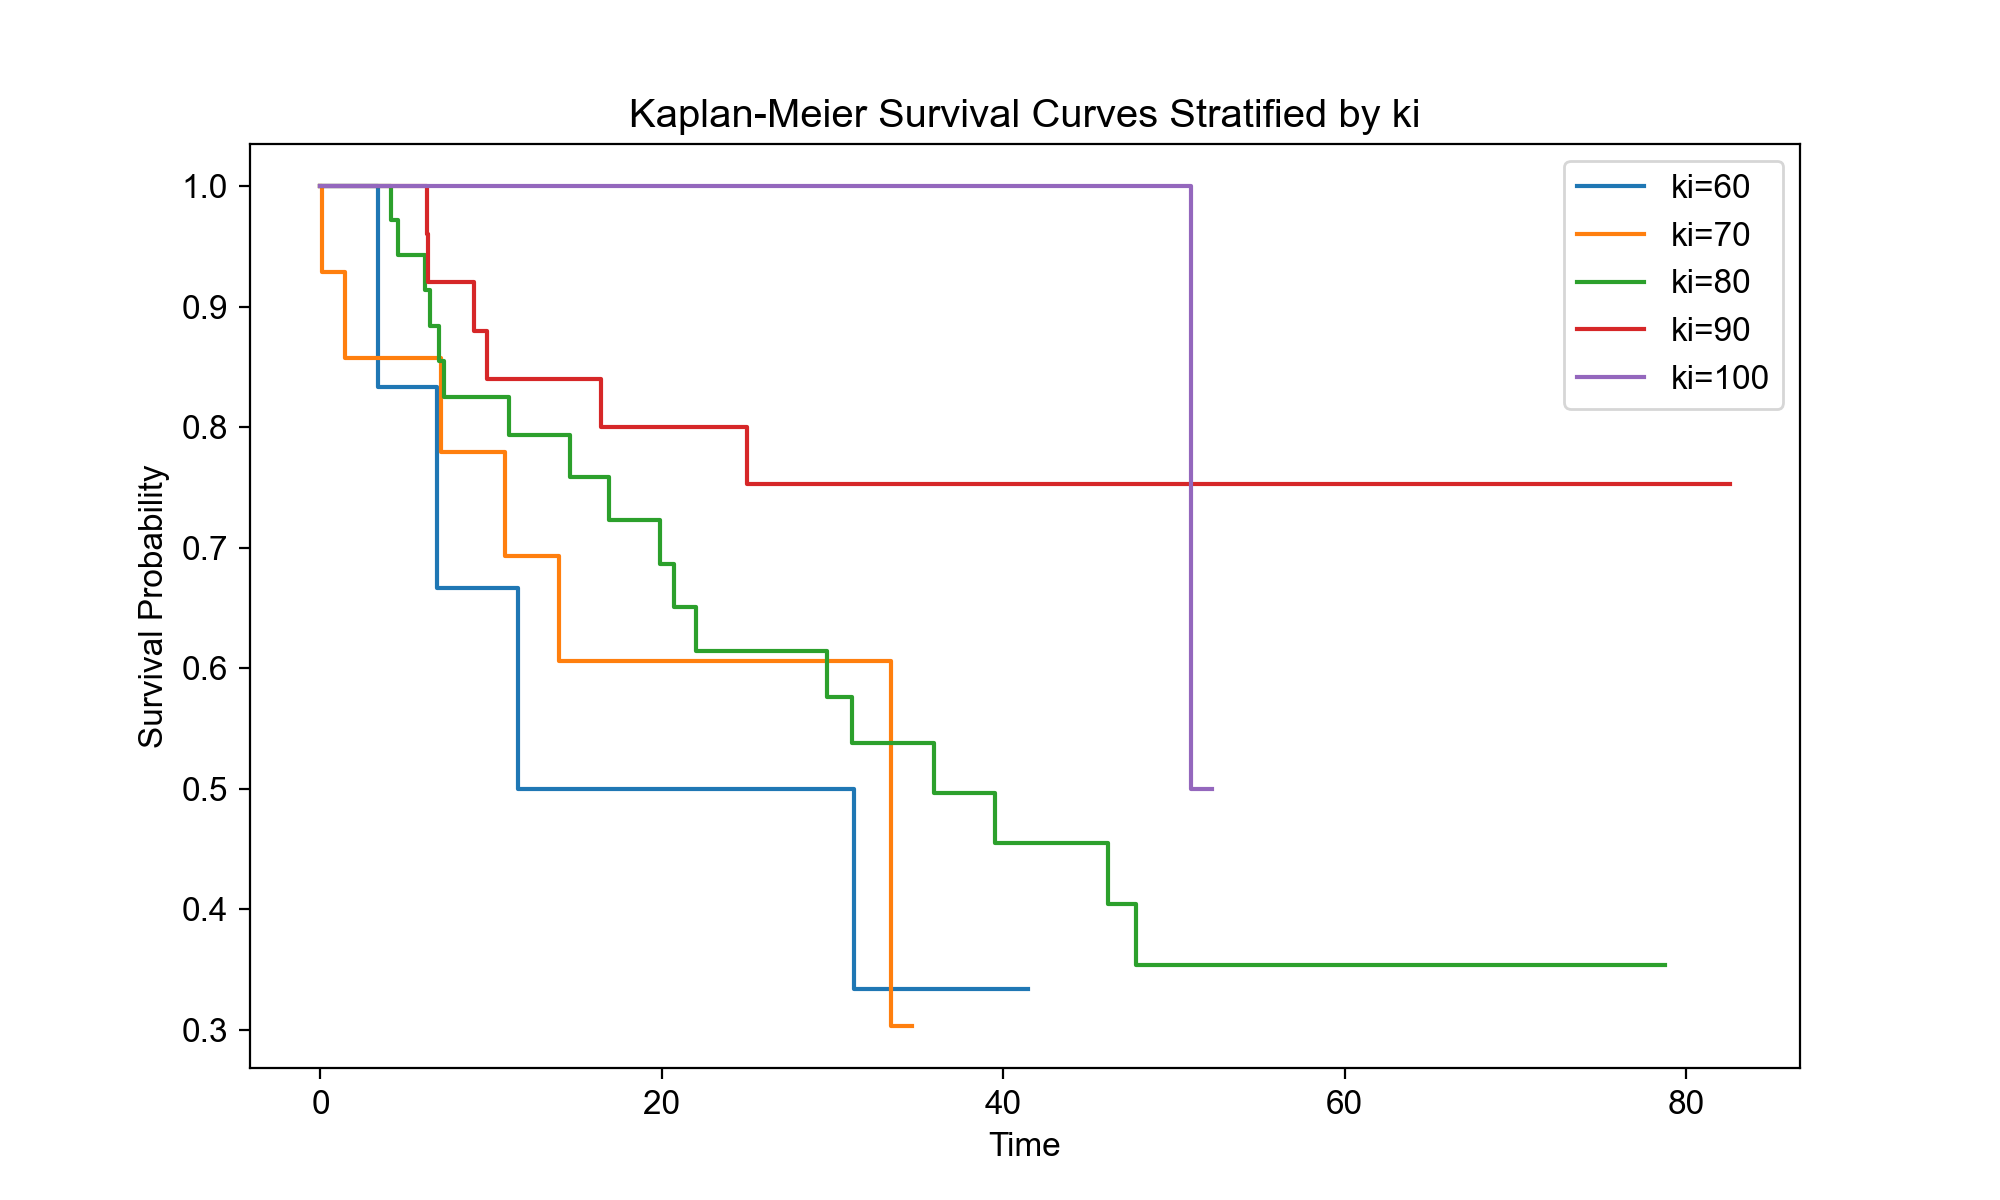

In [75]:
# Replace 40 with 60 in 'ki' column
data['ki'].replace(40, 60, inplace=True)

# Get unique values from 'ki' column
unique_ki_values = data['ki'].unique()

# Initialize KaplanMeierFitter object
kaplan_meier = KaplanMeierFitter()

# Set the figure size
plt.figure(figsize=(10, 6))

# Loop over each unique 'ki' value
for ki in sorted(unique_ki_values):
    # Create a mask for rows where 'ki' equals the current 'ki' value
    ki_mask = data['ki'] == ki

    # Fit the Kaplan-Meier estimator with the 'time' and 'status' for the current 'ki' value
    kaplan_meier.fit(durations=data.loc[ki_mask, 'time'], event_observed=data.loc[ki_mask, 'status'], label=f'ki={ki}')

    # Plot the Kaplan-Meier curve
    kaplan_meier.plot(ci_show=False)

# Set the title and labels of the plot
plt.title('Kaplan-Meier Survival Curves Stratified by ki')
plt.xlabel('Time')
plt.ylabel('Survival Probability')

# Show the legend
plt.legend()

# Display the plot
plt.show()

### Censoring

This example makes use of the data in

Observation (Y ) |Censoring Indicator ($\delta$) | Covariate (X)
-----------------|-------------------------------|-------------------
26.5             | 1                             | 0.1
37.2             | 1                             | 11
57.3             | 1                             | -0.3
90.8             | 0                             | 2.8
20.2             | 0                             | 1.8
89.8             | 0                             | 0.4

(a) Create two groups of observations. In Group 1, $X <2$, whereas
in Group 2, $X \geq 2$. Plot the Kaplan-Meier survival curves corresponding
to the two groups. Be sure to label the curves so that
it is clear which curve corresponds to which group. By eye, does
there appear to be a difference between the two groups’ survival
curves?

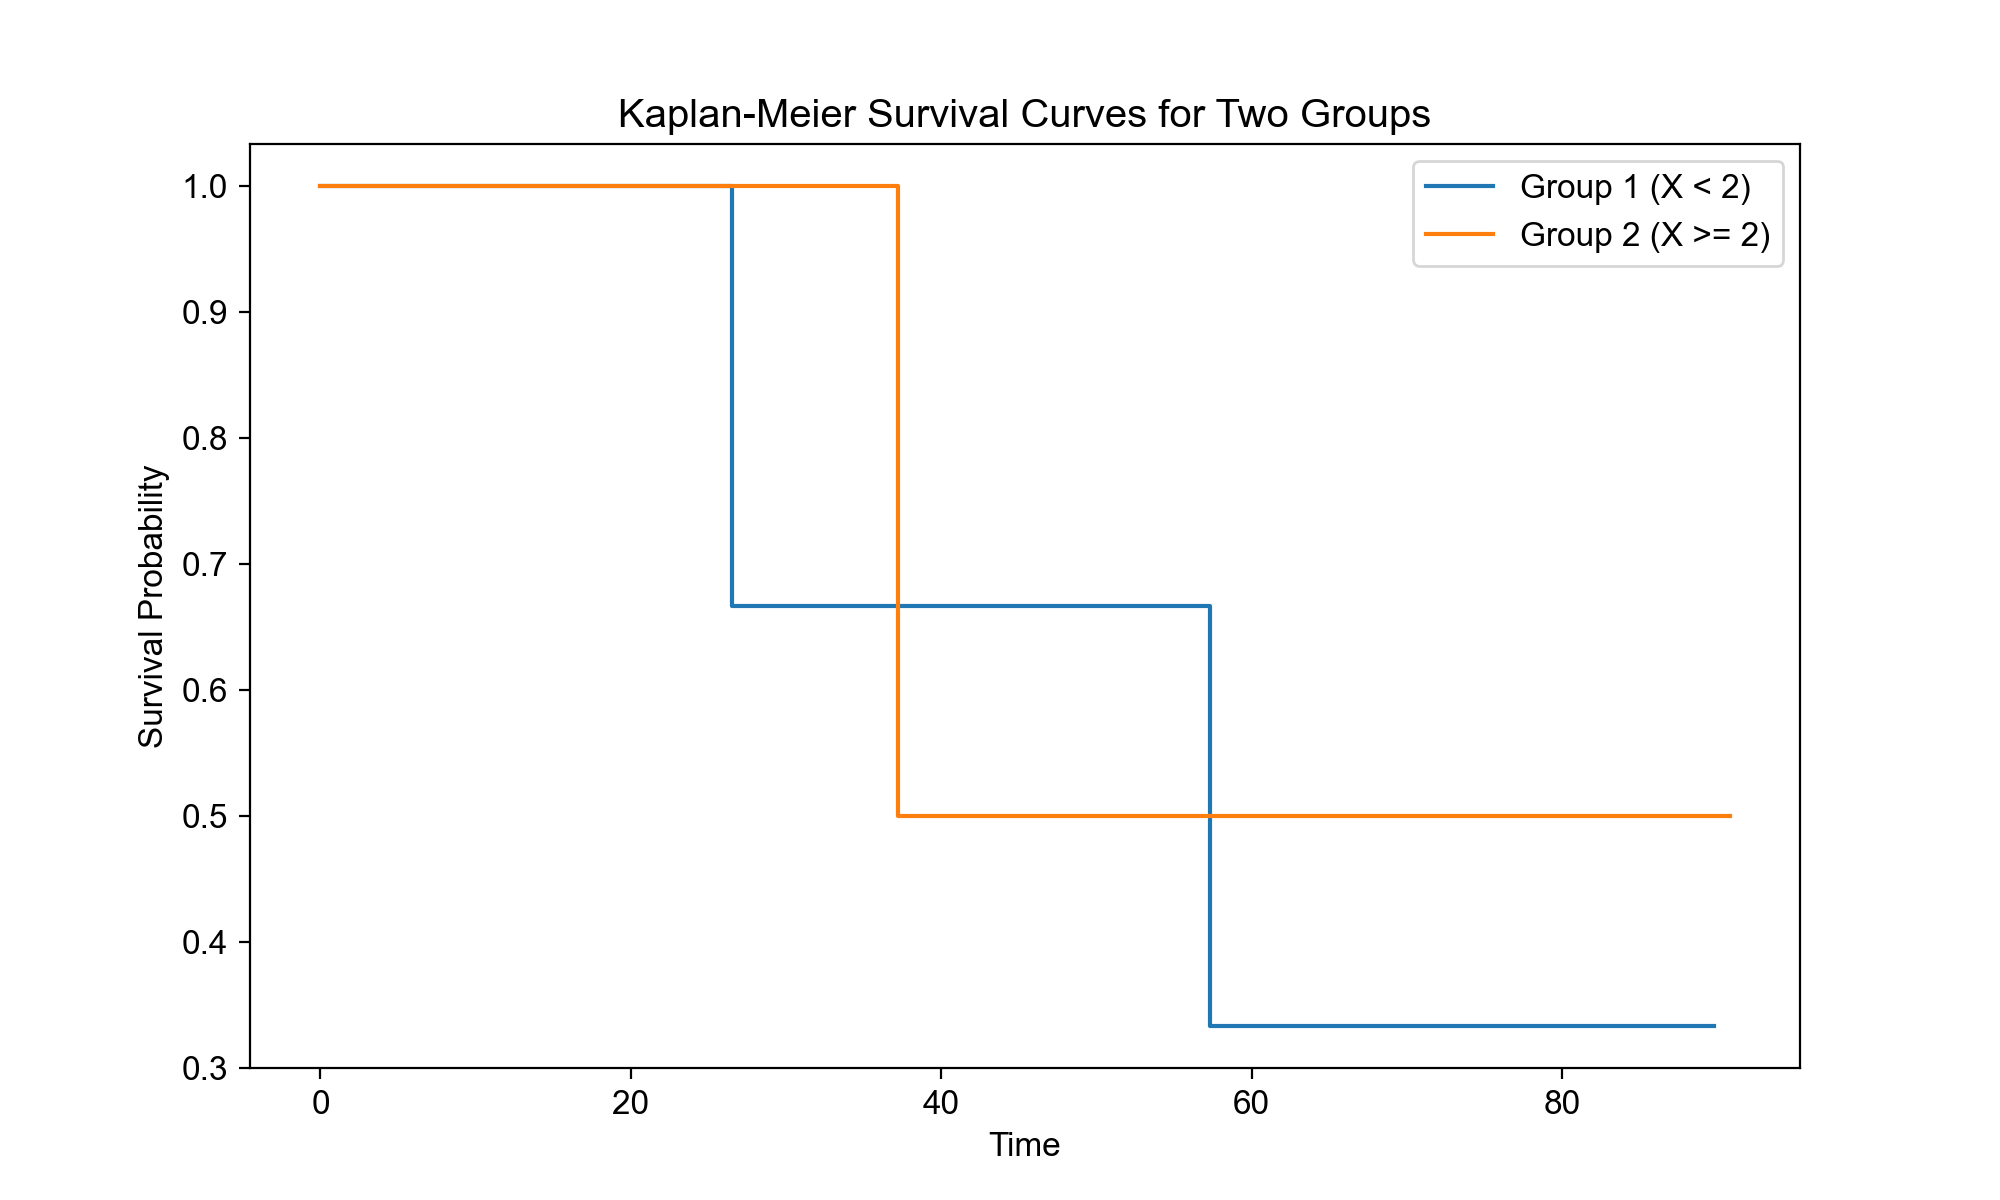

In [83]:
data = {
    'Observation_Y': [26.5, 37.2, 57.3, 90.8, 20.2, 89.8],
    'Censoring_Indicator': [1, 1, 1, 0, 0, 0],
    'Covariate_X': [0.1, 11, -0.3, 2.8, 1.8, 0.4]
}
df = pd.DataFrame(data)
group1 = df[df['Covariate_X'] < 2]
group2 = df[df['Covariate_X'] >= 2]
kmf = KaplanMeierFitter()

plt.figure(figsize=(10, 6))
kmf.fit(durations=group1['Observation_Y'], event_observed=group1['Censoring_Indicator'], label='Group 1 (X < 2)')
kmf.plot(ci_show=False)
kmf.fit(durations=group2['Observation_Y'], event_observed=group2['Censoring_Indicator'], label='Group 2 (X >= 2)')
kmf.plot(ci_show=False)

plt.title('Kaplan-Meier Survival Curves for Two Groups')
plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.legend()
plt.show()

Your answer:

~~~
Please write your answer in full sentences.


~~~

(b) Fit Cox’s proportional hazards model, using the group indicator as a covariate. What is the estimated coefficient? Write a sentence providing the interpretation of this coefficient, in terms of the hazard or the instantaneous probability of the event. Is there evidence that the true coefficient value is non-zero?

In [84]:
from lifelines import CoxPHFitter


df['group_indicator'] = (df['Covariate_X'] >= 2).astype(int)

cph = CoxPHFitter(penalizer=0.01) 
cph.fit(df, 'Observation_Y', event_col='Censoring_Indicator')
print(cph.summary)

                     coef  exp(coef)  se(coef)  coef lower 95%  \
covariate                                                        
Covariate_X      0.313106   1.367667  0.308236       -0.291026   
group_indicator -2.665555   0.069561  3.103584       -8.748467   

                 coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%  \
covariate                                                                   
Covariate_X            0.917238             0.747496             2.502370   
group_indicator        3.417358             0.000159            30.488752   

                 cmp to         z         p  -log2(p)  
covariate                                              
Covariate_X         0.0  1.015798  0.309725  1.690938  
group_indicator     0.0 -0.858863  0.390416  1.356916  


Your answer:

~~~
Please write your answer in full sentences.


~~~

(c) Recall from Section 11.5.2 that in the case of a single binary covariate, the log-rank test statistic should be identical to the score statistic for the Cox model. Conduct a log-rank test to determine whether there is a difference between the survival curves for the two groups. How does the p-value for the log-rank test statistic compare to the p-value for the score statistic for the Cox model from (b)?

In [85]:
from lifelines.statistics import logrank_test
results = logrank_test(
    df[df['group_indicator'] == 0]['Observation_Y'],
    df[df['group_indicator'] == 1]['Observation_Y'],
    event_observed_A=df[df['group_indicator'] == 0]['Censoring_Indicator'],
    event_observed_B=df[df['group_indicator'] == 1]['Censoring_Indicator']
)
results.summary

   test_statistic         p  -log2(p)
0        0.076443  0.782177  0.354433


Your answer:

~~~
Please write your answer in full sentences.


~~~

## Extra Material

### Distributions

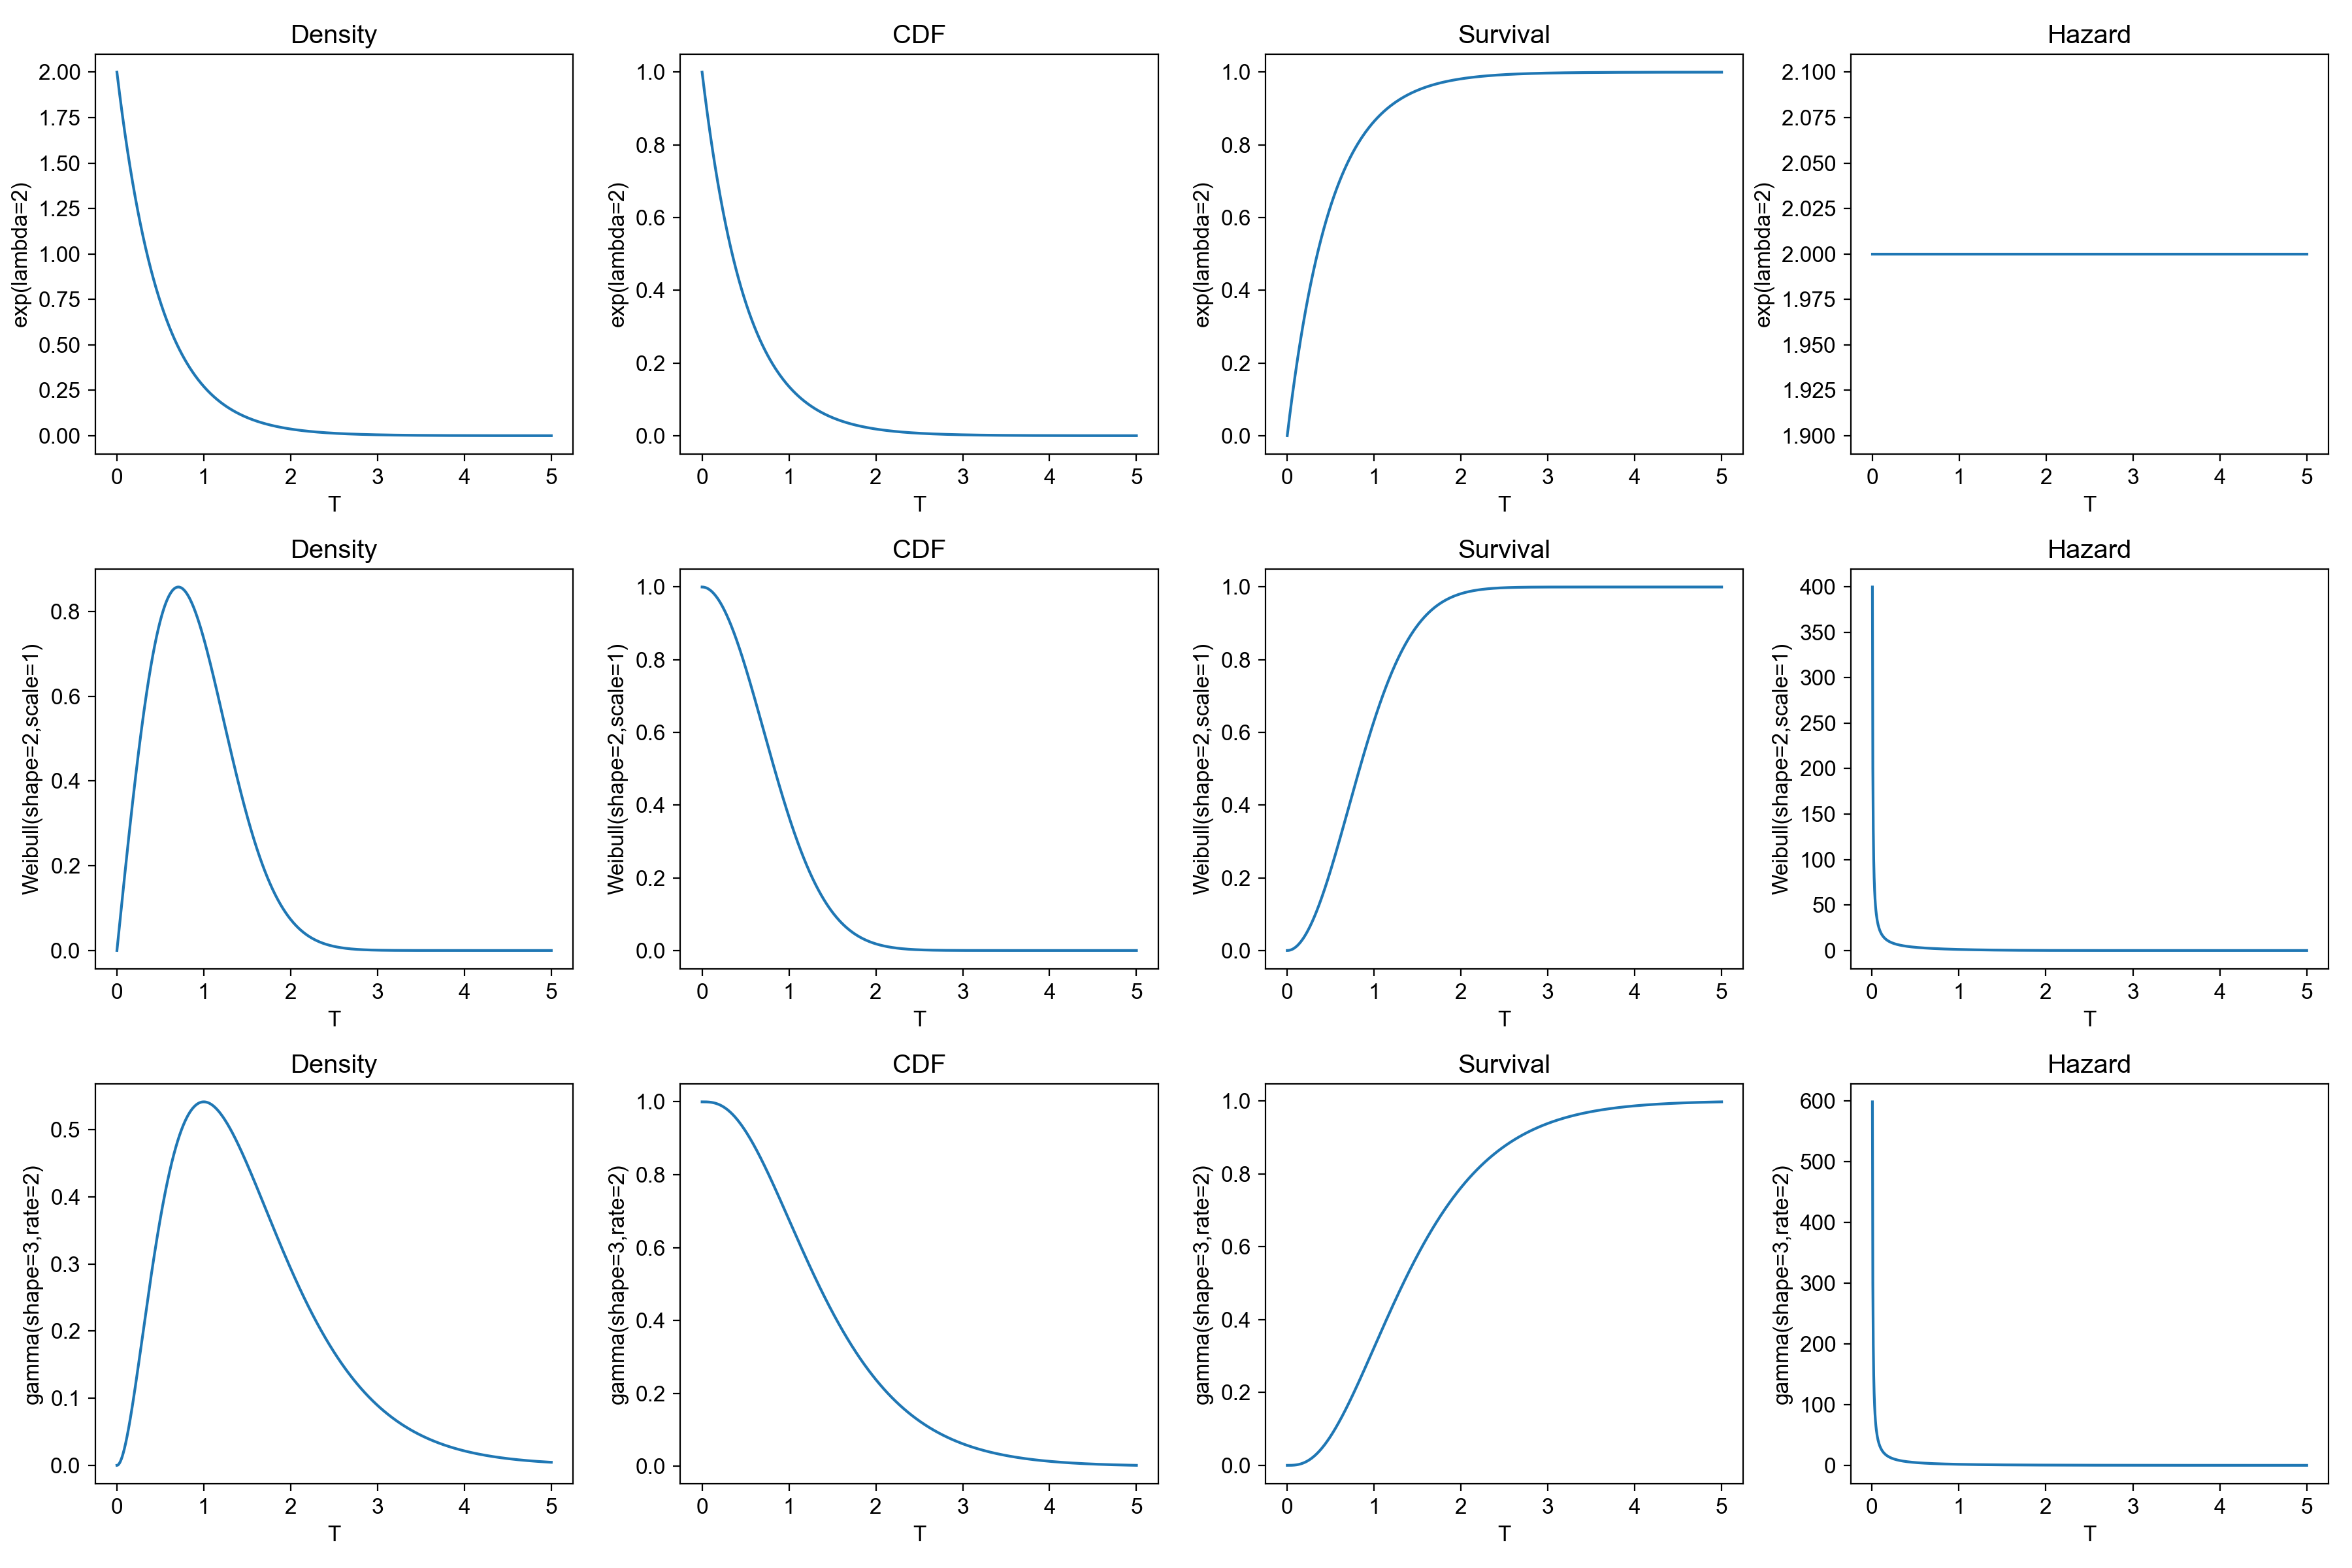

In [86]:
from scipy.stats import expon, weibull_min, gamma

# Define a constant function
def const(x, lam):
    return np.repeat(lam, len(x))

# Set up the plots
fig, axs = plt.subplots(3, 4, figsize=(18, 12))

# Exponential Distribution
x = np.linspace(0, 5, 1000)
lam = 2

# Density plot
axs[0, 0].plot(x, expon.pdf(x, scale=1/lam))
axs[0, 0].set(xlabel='T', ylabel='exp(lambda=2)', title='Density')

# CDF plot
axs[0, 1].plot(x, 1 - expon.cdf(x, scale=1/lam))
axs[0, 1].set(xlabel='T', ylabel='exp(lambda=2)', title='CDF')

# Survival plot
axs[0, 2].plot(x, expon.cdf(x, scale=1/lam))
axs[0, 2].set(xlabel='T', ylabel='exp(lambda=2)', title='Survival')

# Hazard plot
axs[0, 3].plot(x, const(x, lam))
axs[0, 3].set(xlabel='T', ylabel='exp(lambda=2)', title='Hazard')

# Weibull Distribution
shape = 2
scale = 1

# Density plot
axs[1, 0].plot(x, weibull_min.pdf(x, shape, scale=scale))
axs[1, 0].set(xlabel='T', ylabel='Weibull(shape=2,scale=1)', title='Density')

# CDF plot
axs[1, 1].plot(x, 1 - weibull_min.cdf(x, shape, scale=scale))
axs[1, 1].set(xlabel='T', ylabel='Weibull(shape=2,scale=1)', title='CDF')

# Survival plot
axs[1, 2].plot(x, weibull_min.cdf(x, shape, scale=scale))
axs[1, 2].set(xlabel='T', ylabel='Weibull(shape=2,scale=1)', title='Survival')

# Hazard plot
axs[1, 3].plot(x, weibull_min.pdf(x, shape, scale=scale) / weibull_min.cdf(x, shape, scale=scale))
axs[1, 3].set(xlabel='T', ylabel='Weibull(shape=2,scale=1)', title='Hazard')

# Gamma Distribution
shape = 3
rate = 2

# Density plot
axs[2, 0].plot(x, gamma.pdf(x, shape, scale=1/rate))
axs[2, 0].set(xlabel='T', ylabel='gamma(shape=3,rate=2)', title='Density')

# CDF plot
axs[2, 1].plot(x, 1 - gamma.cdf(x, shape, scale=1/rate))
axs[2, 1].set(xlabel='T', ylabel='gamma(shape=3,rate=2)', title='CDF')

# Survival plot
axs[2, 2].plot(x, gamma.cdf(x, shape, scale=1/rate))
axs[2, 2].set(xlabel='T', ylabel='gamma(shape=3,rate=2)', title='Survival')

# Hazard plot
axs[2, 3].plot(x, gamma.pdf(x, shape, scale=1/rate) / gamma.cdf(x, shape, scale=1/rate))
axs[2, 3].set(xlabel='T', ylabel='gamma(shape=3,rate=2)', title='Hazard')

# Adjust layout
plt.tight_layout()
plt.show()